In [66]:
#%pip install tensorflow

### Data Collection.
The dataset includes detailed information on resale transactions of HDB flats between January 1, 2017, and March 30, 2024. The dataset contains 180,154 rows and 11 columns and was downloaded on May 23, 2024.

**Dataset URL**: [HDB Resale Prices](https://beta.data.gov.sg/datasets/d_8b84c4ee58e3cfc0ece0d773c8ca6abc/view)
**HDB RPI URL**:[HDB Resale Prices Index](https://www.hdb.gov.sg/residential/selling-a-flat/overview/resale-statistics)

(141576, 11) (141308, 15) (141308, 52)


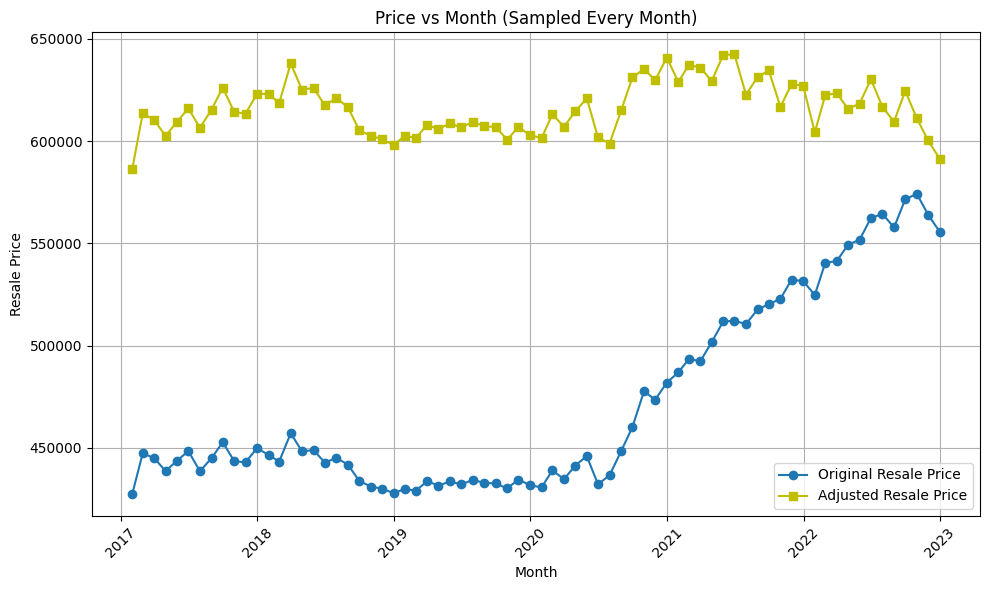

In [67]:
import pandas as pd
import data_config as cfg
import os

df_raw = pd.read_csv('/content/ResaleflatpricesbasedonregistrationdatefromJan2017onwards (1).csv.crdownload')
cfg.save_dataset_info(df_raw, fname='dataset_info.csv')

if not os.path.exists('data/content'):
    os.makedirs('data/content')

df = cfg.adjust_resale_price(df_raw, cut_off_date='2024-04-01')
cfg.visualize_adjusted_price(df[['month', 'resale_price', 'adjusted_price']].copy(), fname='adjusted_price.png')

df_clean = cfg.preprocess_data(df)
print(df_raw.shape, df.shape, df_clean.shape)
df_clean.to_csv('/content/SGHDB2017-2024_clean.csv', index=False)

Install Required Libraries:
Ensure you have the necessary libraries installed. You can install them using pip if they are not already installed.
```sgh
pip install tensorflow pandas scikit-learn
```

### Step 1:
The project starts by importing the pandas library and loading a cleaned CSV file named {SGHDB2017-2024_clean.csv} into a Pandas DataFrame $df$. Then, the {adjusted_price} column, which represents the housing prices to be predicted, is extracted and stored in the variable $y$ and the remaining columns, which serve as features for the model, are stored in the variable $X$.

In [68]:
import pandas as pd
df = pd.read_csv('/content/SGHDB2017-2024_clean.csv')
y = df['adjusted_price'].values   # Target
X = df.drop(columns = 'adjusted_price')  # Features

### Step 2: Prepare the Data:
The dataset is well maintained and prepared by the Singapore government's open data portal. There is no missing data, which simplifies the preprocessing steps.
Load your dataset and prepare it for training. This includes splitting it into training and testing sets and normalizing the features.

In [69]:
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Step 2: Prepare the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize continuous features
continuous_columns = ['flat_type', 'floor_area_sqm',  'floor', 'remaining_lease_months']
binary_columns = df.columns.difference(continuous_columns + ['adjusted_price']).tolist()
scaler = StandardScaler()
X_train_continuous = scaler.fit_transform(X_train[continuous_columns])
X_test_continuous = scaler.transform(X_test[continuous_columns])

# Combine scaled continuous features and binary features
X_train = np.hstack([X_train_continuous, X_train[binary_columns].values])
X_test = np.hstack([X_test_continuous, X_test[binary_columns].values])

### Step 3:
This step defines a function create_regression_model that constructs a feedforward neural network model for regression using TensorFlow's Keras API.

In [76]:
'''import tensorflow as tf

def create_regression_model(input_shape, params={}):
    model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=input_shape),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2), # Dropout layer with 20% dropout rate
    tf.keras.layers.Dense(32, activation='relu'),

    tf.keras.layers.Dense(1)
])

    model.compile(optimizer='adam', loss='mean_squared_error')

    return model
model.summary()'''
import tensorflow as tf
from tensorflow.keras import regularizers

input_shape = (X_train.shape[1],)


model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=input_shape),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,441 (21.25 KB)

 Trainable params: 5,441 (21.25 KB)

 Non-trainable params: 0 (0.00 B)

### Step 4:
The model is trained using the training data  (\(X_{\text{train}}\) and \(y_{\text{train}}\)). The training process runs for 10 epochs (def: \ref{def:epoch}) with a batch size of 32.

In [77]:
# Step 4: Create and train the model
model = create_regression_model(input_shape=[X_train.shape[1]])
history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                    validation_data=(X_test, y_test), verbose=0)

### Step 5:
In the last step, the model is evaluated using various performance metrics and saves the evaluation results to a CSV file.

In [78]:
# Step 4: Evaluate the model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

df_results = pd.DataFrame(columns=['Train', 'Test'])

y_pred = model.predict(X_train)
df_results.loc['Root Mean Squared Error', 'Train'] = np.sqrt(mean_squared_error(y_train, y_pred))
df_results.loc['Mean Aboslute Error', 'Train'] = mean_absolute_error(y_train, y_pred)
df_results.loc['Mean Aboslute Percentage Error', 'Train'] = mean_absolute_percentage_error(y_train, y_pred)*100
df_results.loc['R2 score', 'Train'] = r2_score(y_train, y_pred)

y_pred = model.predict(X_test)
df_results.loc['Root Mean Squared Error', 'Test'] = np.sqrt(mean_squared_error(y_test, y_pred))
df_results.loc['Mean Aboslute Error', 'Test'] = mean_absolute_error(y_test, y_pred)
df_results.loc['Mean Aboslute Percentage Error', 'Test'] = mean_absolute_percentage_error(y_test, y_pred)*100
df_results.loc['R2 score', 'Test'] = r2_score(y_test, y_pred)

df_results = df_results.astype('Float64').round(2)
df_results.to_csv('./data/model_evaluation1.csv')

3092/3092 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [79]:
import matplotlib.pyplot as plt
%matplotlib inline

In [80]:
def plot_predictions(y_test, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, color='blue')
    plt.xlabel('Actual value')
    plt.ylabel('Predicted value')
    plt.title('Predicted vs Actual')

    plt.show()